# BBC News Classification (Part 1)

このノートブックは、次の手順で Part 1 の課題を進めます:

1. **探索的データ解析（EDA）**  
2. **教師なし学習（行列分解によるモデル構築）**  
3. **教師あり学習との比較**

---

## 1. セットアップ & データ読み込み


In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# テキスト処理系
import re
import string

# Scikit-learn 関連
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# 教師あり学習用モデル（比較用）
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# 再現性確保のための乱数シード
RANDOM_SEED = 42


### データ読み込み

今回の Kaggle コンペティションでは以下のファイルが提供されています：
- **BBC News Train.csv**（学習用：1490レコード）
- **BBC News Test.csv**（テスト用：736レコード）
- **BBC News Sample Solution.csv**（提出フォーマットのサンプル）

フォルダ構成は以下を想定しています:
.
├── README.md
├── learn-ai-bbc
│   ├── BBC News Sample Solution.csv
│   ├── BBC News Test.csv
│   └── BBC News Train.csv
└── main.ipynb


In [55]:
# パスは環境に合わせて調整してください
train_df = pd.read_csv('./learn-ai-bbc/BBC News Train.csv')
test_df = pd.read_csv('./learn-ai-bbc/BBC News Test.csv')

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# トレーニングデータをざっと確認
train_df.head()


Train shape: (1490, 3)
Test shape: (735, 2)


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


トレーニングセットには以下のような列があります：
- **ArticleId**: ユニークID
- **Article**: 記事のテキスト本文
- **Category**: カテゴリ（sport, tech, business, entertainment, politics のいずれか）

---
## 2. 探索的データ解析 (EDA)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
None
         ArticleId
count  1490.000000
mean   1119.696644
std     641.826283
min       2.000000
25%     565.250000
50%    1112.500000
75%    1680.750000
max    2224.000000


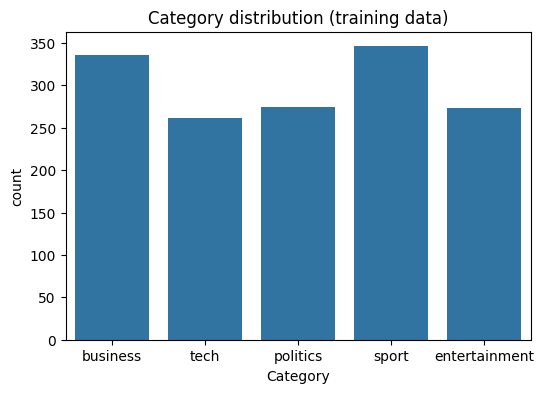

In [56]:
# トレーニングデータの基本情報
print(train_df.info())
print(train_df.describe())

# カテゴリの分布を可視化
plt.figure(figsize=(6,4))
sns.countplot(x='Category', data=train_df)
plt.title("Category distribution (training data)")
plt.show()


### 初期観察

- カテゴリの偏り（不均衡）があるかどうか
- テキストの長さなどを確認する

#### テキスト長の分布


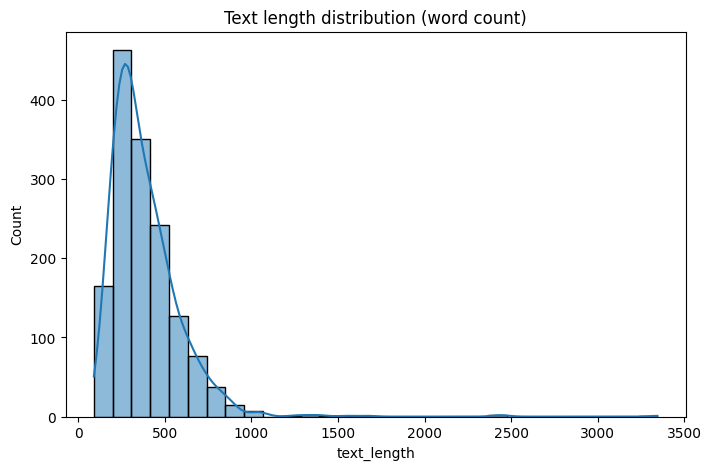

,text_length
count,1490.000000
mean,385.012752
std,210.898616
min,90.000000
25%,253.000000
50%,337.000000
75%,468.750000
max,3345.000000


In [57]:
# テキスト長をカウントしてみる
train_df['text_length'] = train_df['Text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8,5))
sns.histplot(train_df['text_length'], bins=30, kde=True)
plt.title("Text length distribution (word count)")
plt.show()

train_df[['Text', 'text_length']].describe()


### データクレンジングの方針

- 欠損値（NaN）があるか確認
- 句読点の削除や小文字化
- ストップワード除去やステミング／ルマタイジングを行うかどうか

ここでは簡単な方針として：
1. 小文字化
2. 句読点・数字の削除
3. （必要に応じて）ストップワード除去


In [58]:
# 欠損値の確認
print("Missing values in training set:\n", train_df.isnull().sum())
print("Missing values in test set:\n", test_df.isnull().sum())


Missing values in training set:
 ArticleId      0
Text           0
Category       0
text_length    0
dtype: int64
Missing values in test set:
 ArticleId    0
Text         0
dtype: int64


---
## 3. テキスト前処理 & 特徴量作成

ここでは、テキストクリーニング関数を作成し、**TF-IDF**（もしくは別の手法）によってベクトル化してみます。


In [59]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
    シンプルなテキストクリーニング：
    1. 小文字化
    2. 句読点や数字の削除
    3. ホワイトスペースの整理
    4. （オプション）ストップワード除去
    """
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # 句読点・数字などを削除
    text = text.split()
    # text = [word for word in text if word not in STOPWORDS]  # ストップワードを除去する場合
    text = ' '.join(text)
    return text

# トレーニング、テスト両方に適用
train_df['cleaned_text'] = train_df['Text'].apply(clean_text)
test_df['cleaned_text']  = test_df['Text'].apply(clean_text)

train_df.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/soma.utsumi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,ArticleId,Text,Category,text_length,cleaned_text
0,1833,worldcom ex-boss launches defence lawyers defe...,business,301,worldcom exboss launches defence lawyers defen...
1,154,german business confidence slides german busin...,business,325,german business confidence slides german busin...
2,1101,bbc poll indicates economic gloom citizens in ...,business,514,bbc poll indicates economic gloom citizens in ...
3,1976,lifestyle governs mobile choice faster bett...,tech,634,lifestyle governs mobile choice faster better ...
4,917,enron bosses in $168m payout eighteen former e...,business,355,enron bosses in m payout eighteen former enron...


### ベクトル化

次に、クレンジング後のテキストを **TF-IDF** で特徴量ベクトル化します。 


In [60]:
# CountVectorizer でも構いませんが、例として TfidfVectorizer を使用
tfidf = TfidfVectorizer(
    max_features=2000,       # 特徴量の上限。調整可能
    stop_words='english',    # 追加で英語のストップワードを適用
    min_df=2,                # 非常に稀な単語を無視
    max_df=0.8               # 極端に出現頻度の高い単語を無視
)

# トレーニングデータの cleaned_text を元に fit
X_train_tfidf = tfidf.fit_transform(train_df['cleaned_text'])

# テストデータにはまだ transform のみ（後ほど必要に応じて行う）


**ポイント**:  
**教師なし学習**（行列分解）で、テストデータを学習に含めるかどうかは議論の余地があります。  
実際には「未知のテストデータは学習に使わない」が一般的ですが、全テキストでトピックを発見する手法としてはテストデータを含める場合もあります。  
ここでは「テストデータは学習に含めない」方針で進め、あとでテストデータを transform のみして結果を得ます。

---
## 4. 教師なし学習 (行列分解: NMF)

`sklearn.decomposition` の **NMF** を使い、以下のように行列分解します:

1. TF-IDF 行列を `W * H` に分解
2. 行列 **W** は「文書×トピック」行列、行列 **H** は「トピック×単語」行列

文書ごとに最もウェイトが大きいトピックを予測ラベルにする方法などで精度を測り、元のカテゴリと比較します。


In [61]:
num_topics = 5  # カテゴリが5種類なので、とりあえず n_components=5 としてみる

nmf_model = NMF(
    n_components=num_topics, 
    random_state=RANDOM_SEED,
    init='nndsvd',  # NMFでよく使われる初期化
    max_iter=200    # 適宜調整可能
)

W = nmf_model.fit_transform(X_train_tfidf)  # 形状: (文書数, トピック数)
H = nmf_model.components_                   # 形状: (トピック数, 単語数)

print("W shape:", W.shape)
print("H shape:", H.shape)


W shape: (1490, 5)
H shape: (5, 2000)


### NMFで得られたトピックの解釈

`H` の各行（各トピック）において、値が大きい単語がそのトピックの代表語です。


In [62]:
feature_names = tfidf.get_feature_names_out()

def show_top_words_per_topic(H, feature_names, top_n=10):
    for idx, topic_vec in enumerate(H):
        # 値が大きい順にソート
        top_indices = topic_vec.argsort()[::-1][:top_n]
        top_words = [feature_names[i] for i in top_indices]
        print(f"トピック {idx+1}:", ", ".join(top_words))

show_top_words_per_topic(H, feature_names, top_n=10)


トピック 1: england, game, win, wales, ireland, cup, players, play, france, chelsea
トピック 2: mr, labour, blair, election, brown, party, government, minister, prime, howard
トピック 3: bn, growth, economy, year, sales, market, bank, oil, economic, shares
トピック 4: film, best, awards, award, actor, films, actress, festival, won, director
トピック 5: people, mobile, music, phone, technology, digital, users, software, phones, broadband


トピックがどのカテゴリに対応しているかを推測するために、代表語を見て「スポーツっぽい」「政治っぽい」などを探ります。

### トピックからカテゴリへの割り当て

単純な方法として：
1. 文書（訓練データ）について `W` の最大値のトピックを取得
2. その文書が実際どのカテゴリかを見て、多数決で「トピック → 推定カテゴリ」を決める



In [63]:
train_topics = np.argmax(W, axis=1)  # 各文書において最も値が大きいトピック
train_df['topic'] = train_topics

# トピック×カテゴリで集計
topic_category_df = train_df.groupby(['topic', 'Category']).size().reset_index(name='count')
topic_category_df


,topic,Category,count
0,0,business,1
1,0,entertainment,4
2,0,politics,2
3,0,sport,343
4,0,tech,5
5,1,business,15
6,1,entertainment,7
7,1,politics,252
8,1,tech,1
9,2,business,307


これで「トピックがいくつの時は実際には何のカテゴリが多いか」を確認し、  
一番多いカテゴリをトピックのラベルとします。


In [64]:
# topic -> label のマッピングを作成
topic_to_label = {}
for t in range(num_topics):
    subset = topic_category_df[topic_category_df['topic'] == t]
    # 'count' が最大のカテゴリを取得
    assigned_cat = subset.loc[ subset['count'].idxmax(), 'Category']
    topic_to_label[t] = assigned_cat

topic_to_label


{0: 'sport', 1: 'politics', 2: 'business', 3: 'entertainment', 4: 'tech'}

#### トレーニングデータに対する予測結果


In [65]:
train_df['unsupervised_pred'] = train_df['topic'].apply(lambda t: topic_to_label[t])
accuracy_unsupervised_train = accuracy_score(train_df['Category'], train_df['unsupervised_pred'])
print("教師なし (NMF) のトレーニング精度:", accuracy_unsupervised_train)

print("Classification Report (Train):\n", 
      classification_report(train_df['Category'], train_df['unsupervised_pred']))


教師なし (NMF) のトレーニング精度: 0.9167785234899329
Classification Report (Train):
                precision    recall  f1-score   support

     business       0.94      0.91      0.93       336
entertainment       0.97      0.78      0.87       273
     politics       0.92      0.92      0.92       274
        sport       0.97      0.99      0.98       346
         tech       0.80      0.96      0.87       261

     accuracy                           0.92      1490
    macro avg       0.92      0.91      0.91      1490
 weighted avg       0.92      0.92      0.92      1490



#### テストデータに対する予測
1. TF-IDFベクトル化（`tfidf.transform()`）
2. `nmf_model.transform()` でトピック分布を得る
3. 最も値が大きいトピックから、上記の `topic_to_label` を使ってカテゴリを予測
4. Kaggle に提出するための CSV を作成

---


In [66]:
X_test_tfidf = tfidf.transform(test_df['cleaned_text'])
W_test = nmf_model.transform(X_test_tfidf)
test_topics = np.argmax(W_test, axis=1)
test_preds_nmf = [topic_to_label[t] for t in test_topics]

# Kaggle本番ではテストラベルがないので精度はローカルでは測れないが
# 提出用ファイルを作成する手順の一例:
test_df['pred'] = test_preds_nmf
submission_nmf = test_df[['ArticleId','pred']].rename(columns={'pred':'Category'})
submission_nmf.to_csv('nmf_submission.csv', index=False)


> **注意**: 実際のKaggle環境では、テストセットに真のラベルが付与されていないため、ローカルで精度を測定できません。提出してリーダーボードで確認します。

---

## 5. 教師あり学習との比較

トレーニングデータにはラベルがあるため、**ロジスティック回帰**や**ナイーブベイズ**などで教師あり学習を行い、NMFによる教師なし手法と比べてみましょう。


In [67]:
# 教師ありモデル用に X, y を準備
X_train_sup = X_train_tfidf
y_train_sup = train_df['Category']

# 例：ロジスティック回帰
clf_lr = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
clf_lr.fit(X_train_sup, y_train_sup)

# トレーニングセットで評価
train_preds_lr = clf_lr.predict(X_train_sup)
accuracy_lr_train = accuracy_score(y_train_sup, train_preds_lr)
print("ロジスティック回帰（Train Accuracy）:", accuracy_lr_train)

print("Classification Report (Train):\n",
      classification_report(y_train_sup, train_preds_lr))


ロジスティック回帰（Train Accuracy）: 0.9932885906040269
Classification Report (Train):
                precision    recall  f1-score   support

     business       0.99      0.99      0.99       336
entertainment       1.00      1.00      1.00       273
     politics       0.99      0.99      0.99       274
        sport       1.00      1.00      1.00       346
         tech       0.99      0.99      0.99       261

     accuracy                           0.99      1490
    macro avg       0.99      0.99      0.99      1490
 weighted avg       0.99      0.99      0.99      1490



### テストデータでの評価（教師あり）


In [68]:
X_test_sup = tfidf.transform(test_df['cleaned_text'])
test_preds_lr = clf_lr.predict(X_test_sup)

# これもKaggle提出用例
# submission_lr = test_df[['ArticleId']].copy()
# submission_lr['Category'] = test_preds_lr
# submission_lr.to_csv("lr_submission.csv", index=False)


他にもナイーブベイズなどを試して、パフォーマンスを比較してもよいでしょう。


In [69]:
clf_nb = MultinomialNB()
clf_nb.fit(X_train_sup, y_train_sup)
train_preds_nb = clf_nb.predict(X_train_sup)
accuracy_nb_train = accuracy_score(y_train_sup, train_preds_nb)
print("ナイーブベイズ（Train Accuracy）:", accuracy_nb_train)


ナイーブベイズ（Train Accuracy）: 0.9838926174496644


### 考察・比較
- 教師なし(NMF) の精度 vs 教師あり(ロジスティック回帰, ナイーブベイズなど) の精度
- トレーニングデータサイズを一部に減らして教師あり学習すると、精度はどう落ちるか？
- 過学習の傾向は？
- データ効率は？（少ないラベルでどの程度性能が出るか など）

---

## 6. まとめ & 次のステップ
- EDA で分かった点の要約
- 行列分解による手法と教師あり手法の比較
- 精度向上のアイデア（ハイパーパラメータの調整、テキスト処理の工夫、アンサンブルなど）
- 参考文献リスト

---

## 参考文献
- [scikit-learn NMF の公式ドキュメント](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)
- [TfidfVectorizer のドキュメント](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
- ...
